In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq '/content/drive/MyDrive/all/galaxy_zoo/images_gz2.zip'

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
filename = pd.read_csv('/content/drive/MyDrive/all/galaxy_zoo/gz2_filename_mapping.csv')
task = pd.read_csv('/content/drive/MyDrive/all/galaxy_zoo/gz2_hart16.csv')

In [5]:
# image data sample -> original and extra
filename = filename[(filename['sample'] == 'original') | (filename['sample'] == 'extra')]

In [6]:

# table_data에 있는 image_data와 실제 있는 데이터 확인
# 누락된 파일 목록
missing_image = []

for idx, row in filename.iterrows():
    file_path = '/content/images/' + str(filename.loc[idx, 'asset_id']) + '.jpg'
    if not os.path.exists(file_path):
        missing_image.append(idx)

# 누락된 이미지 목록 출력
print(f'Missing image index : {missing_image}')
print(len(missing_image))



# 가지고 있는 이미지 데이터 <=> filename
filename_drop = filename.drop(index = missing_image)
filename_drop = filename_drop.reset_index(drop = True)

Missing image index : [0, 1, 9, 61, 63, 66, 90, 103, 110, 112, 121, 158, 159, 165, 166, 168, 169, 232, 233, 247, 249, 261, 275, 296, 300, 307, 329, 345, 349, 350, 360, 373, 382, 385, 442, 448, 449, 454, 498, 500, 503, 504, 508, 513, 516, 518, 521, 529, 541, 543, 550, 551, 552, 559, 565, 588, 598, 601, 612, 614, 616, 651, 671, 676, 705, 715, 721, 723, 732, 765, 766, 785, 793, 797, 800, 821, 822, 829, 836, 869, 870, 908, 914, 917, 918, 924, 927, 939, 943, 946, 948, 968, 971, 985, 1023, 1047, 1059, 1085, 1098, 1104, 1151, 1152, 1153, 1154, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1172, 1173, 1174, 1176, 1178, 1191, 1192, 1193, 1200, 1211, 1223, 1225, 1229, 1241, 1242, 1268, 1273, 1278, 1280, 1284, 1286, 1296, 1300, 1303, 1307, 1330, 1349, 1365, 1375, 1450, 1451, 1456, 1462, 1471, 1472, 1477, 1498, 1508, 1522, 1547, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1578, 1603, 1609, 1628, 1637, 1643, 1644, 1660, 1661, 1

## task01

In [7]:
# task01 label를 구하기 위해서 target  추출

task01_debiased = task.loc[:,['t01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a02_features_or_disk_debiased', 't01_smooth_or_features_a03_star_or_artifact_debiased']]
task01_flag = task.loc[:,['t01_smooth_or_features_a01_smooth_flag', 't01_smooth_or_features_a02_features_or_disk_flag', 't01_smooth_or_features_a03_star_or_artifact_flag'] ]

# task01 debiased 값 중 가장큰 값을 인덱스 저장
task01_debiased['target'] = np.argmax(np.array(task01_debiased), axis = 1)
#task01_debiased['target'].value_counts()

# task01 flag 값 중 가장큰 값을 인덱스 저장(모든 값이 값을 경우 있음)
task01_flag['3'] = 1
task01_flag['target'] = np.argmax(np.array(task01_flag), axis =1)

# 인덱스 값을 저장하여 2로 저장 -> flag -> 신뢰성 유무 판단 0, 1
task01_flag['True'] = 0
task01_flag['True'][task01_flag['target'] != 3] = 1


# task01 신뢰성 O, 라벨값, ID, gz2_class
task01_O = task.loc[task01_flag[task01_flag['True']== 1].index, ['dr7objid','gz2_class']]
task01_O['target'] = task01_debiased['target']

# 신뢰성 O : 라벨2 데이터 개수(2) 매우 적음
# 신뢰성 X : 라벨2 데이터 개수 592 모두 사용하기
# task01['target'].value_counts()

task01_debiased['True'] = task01_flag['True']
task01_X = task.loc[task01_debiased[(task01_debiased['True'] == 0) & (task01_debiased['target']== 2)].index, ['dr7objid','gz2_class']]
task01_X['target'] = task01_debiased['target']


# 신뢰성 0 + 신뢰성 X
task01 = pd.concat([task01_O,task01_X],ignore_index=True)

# 이미지 데이터 유무 판단
task01['image']=task01['dr7objid'].isin(filename_drop['objid'])
task01 = task01[task01['image'] == 1].reset_index(drop=True)

# filename task 병합
image_task01 = filename_drop.merge(task01, left_on='objid', right_on='dr7objid', how='inner')
image_task01.drop(columns=['sample','dr7objid', 'image'], inplace= True)

## deeplearning

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


import cv2 as cv
from google.colab.patches import cv2_imshow

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.dir = '/content/images/'


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dir+ str(self.dataframe.loc[idx, 'asset_id'])+'.jpg'
        target = self.dataframe.loc[idx, 'target']

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, target



In [11]:
from sklearn.model_selection import train_test_split

data = image_task01
labels = image_task01['target']

train_data, test_data, _, _ = train_test_split(data, labels, test_size=0.2, stratify=labels)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# 분할된 데이터로부터 새로운 CustomDataset 인스턴스 생성
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# DataLoader 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

dataloader_dict = {'train': train_loader, 'test': test_loader}


-------

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


## CNN 기본

In [32]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride =2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride =2)
        )

        self.fc = torch.nn.Linear(106*106*64, 3 , bias = True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [33]:
model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=719104, out_features=3, bias=True)
)


In [34]:
from torchsummary import summary
summary(model, input_size=(3, 424, 424))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 424, 424]             896
              ReLU-2         [-1, 32, 424, 424]               0
         MaxPool2d-3         [-1, 32, 212, 212]               0
            Conv2d-4         [-1, 64, 212, 212]          18,496
              ReLU-5         [-1, 64, 212, 212]               0
         MaxPool2d-6         [-1, 64, 106, 106]               0
            Linear-7                    [-1, 3]       2,157,315
Total params: 2,176,707
Trainable params: 2,176,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.06
Forward/backward pass size (MB): 148.13
Params size (MB): 8.30
Estimated Total Size (MB): 158.49
----------------------------------------------------------------


### train

In [35]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):

    since = time.time()
    best_acc = 0
    progress = []

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            counter = 0
            epoch_loss = 0.0
            epoch_corrects = 0


            for inputs, labels in tqdm(dataloader_dict[phase]):
                labels= torch.tensor(list(map(int, labels)))

                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        counter += 1
                        if counter % 1 ==0:
                            progress.append(loss.item())
                        if counter % 1000 == 0:
                            print("counter = ", counter)

                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item()/ len(inputs)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.10f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

    return model, progress


def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [ ]:
learning_rate = 1e-3

# model = CNN().to(device)
# dataloader_dict = {'train': train_loader, 'test': test_loader}
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 5

model, progress= train_model(model, dataloader_dict, criterion, optimizer, num_epoch)
plot_progress(progress)

## LeNet-5

### model

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*103*103, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=339488, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 424, 424))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 420, 420]           1,216
              ReLU-2         [-1, 16, 420, 420]               0
         MaxPool2d-3         [-1, 16, 210, 210]               0
            Conv2d-4         [-1, 32, 206, 206]          12,832
              ReLU-5         [-1, 32, 206, 206]               0
         MaxPool2d-6         [-1, 32, 103, 103]               0
            Linear-7                  [-1, 512]     173,818,368
            Linear-8                    [-1, 3]           1,539
Total params: 173,833,955
Trainable params: 173,833,955
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.06
Forward/backward pass size (MB): 71.76
Params size (MB): 663.12
Estimated Total Size (MB): 736.95
----------------------------------------------------------------


### train

Epoch 1/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0004009838 Acc: 0.8194


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0003102364 Acc: 0.8609
Training complete in 18m 15s
Best val Acc: 0.860922
Epoch 2/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0003243594 Acc: 0.8585


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0003022303 Acc: 0.8633
Training complete in 36m 11s
Best val Acc: 0.863270
Epoch 3/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002998389 Acc: 0.8688


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0002865723 Acc: 0.8749
Training complete in 54m 14s
Best val Acc: 0.874876
Epoch 4/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002890694 Acc: 0.8730


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0002748087 Acc: 0.8785
Training complete in 72m 25s
Best val Acc: 0.878513
Epoch 5/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002801987 Acc: 0.8766


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0002777285 Acc: 0.8723
Training complete in 90m 30s
Best val Acc: 0.878513


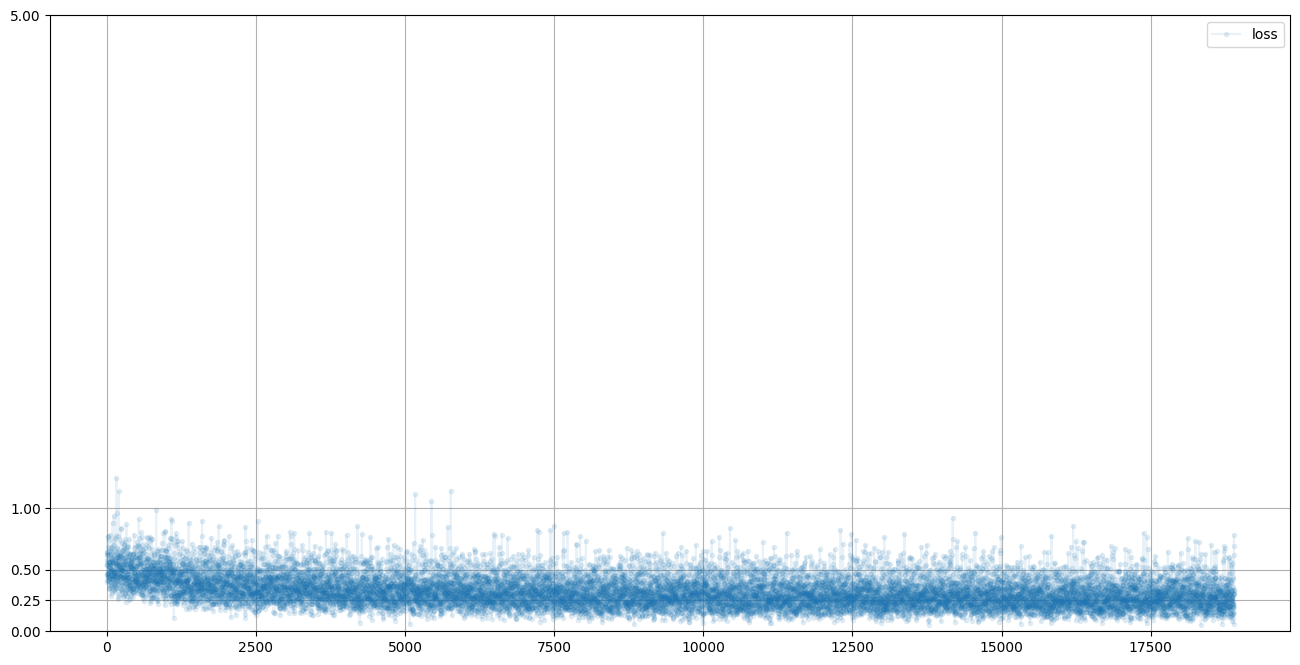

In [ ]:
learning_rate = 1e-3

# model = LeNet().to(device)
# dataloader_dict = {'train': train_loader, 'test': test_loader}
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 5

model, progress1= train_model(model, dataloader_dict, criterion, optimizer, num_epoch)
plot_progress(progress1)

## AlexNet

###model

In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 424, 424))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 105, 105]          23,296
              ReLU-2         [-1, 64, 105, 105]               0
         MaxPool2d-3           [-1, 64, 52, 52]               0
            Conv2d-4          [-1, 192, 52, 52]         307,392
              ReLU-5          [-1, 192, 52, 52]               0
         MaxPool2d-6          [-1, 192, 25, 25]               0
            Conv2d-7          [-1, 384, 25, 25]         663,936
              ReLU-8          [-1, 384, 25, 25]               0
            Conv2d-9          [-1, 256, 25, 25]         884,992
             ReLU-10          [-1, 256, 25, 25]               0
           Conv2d-11          [-1, 256, 25, 25]         590,080
             ReLU-12          [-1, 256, 25, 25]               0
        MaxPool2d-13          [-1, 256, 12, 12]               0
AdaptiveAvgPool2d-14            [-1, 25

### train

Epoch 1/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0004352658 Acc: 0.8038


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0003213576 Acc: 0.8598
Training complete in 19m 11s
Best val Acc: 0.859798
Epoch 2/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0003233921 Acc: 0.8561


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0002926822 Acc: 0.8706
Training complete in 37m 10s
Best val Acc: 0.870577
Epoch 3/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002940947 Acc: 0.8702


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0002747889 Acc: 0.8776
Training complete in 54m 53s
Best val Acc: 0.877554
Epoch 4/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002810544 Acc: 0.8763


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0003500848 Acc: 0.8305
Training complete in 72m 24s
Best val Acc: 0.877554
Epoch 5/5
--------------------


  0%|          | 0/3780 [00:00<?, ?it/s]

counter =  1000
counter =  2000
counter =  3000
train Loss: 0.0002764696 Acc: 0.8798


  0%|          | 0/945 [00:00<?, ?it/s]

test Loss: 0.0003404087 Acc: 0.8525
Training complete in 89m 44s
Best val Acc: 0.877554


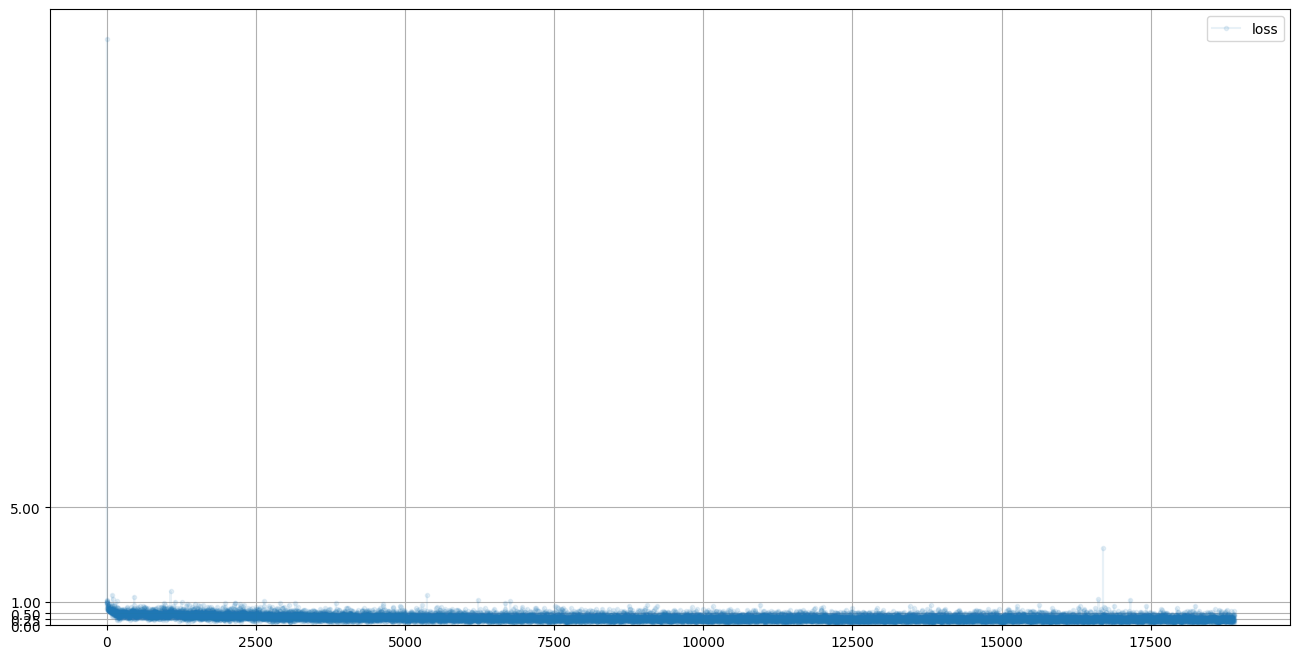

In [ ]:
learning_rate = 1e-3

# model = AlexNet().to(device)
# dataloader_dict = {'train': train_loader, 'test': test_loader}
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 5

model, progress2= train_model(model, dataloader_dict, criterion, optimizer, num_epoch)
plot_progress(progress2)

## VGG

### model

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

In [ ]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

OUTPUT_DIM = 3
model = VGG(vgg11_layers, OUTPUT_DIM).to(device)
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 424, 424))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 424, 424]           1,792
       BatchNorm2d-2         [-1, 64, 424, 424]             128
              ReLU-3         [-1, 64, 424, 424]               0
         MaxPool2d-4         [-1, 64, 212, 212]               0
            Conv2d-5        [-1, 128, 212, 212]          73,856
       BatchNorm2d-6        [-1, 128, 212, 212]             256
              ReLU-7        [-1, 128, 212, 212]               0
         MaxPool2d-8        [-1, 128, 106, 106]               0
            Conv2d-9        [-1, 256, 106, 106]         295,168
      BatchNorm2d-10        [-1, 256, 106, 106]             512
             ReLU-11        [-1, 256, 106, 106]               0
           Conv2d-12        [-1, 256, 106, 106]         590,080
      BatchNorm2d-13        [-1, 256, 106, 106]             512
             ReLU-14        [-1, 256, 1

### train

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    counter  = 0
    progress= []

    model.train()
    for (x, y) in tqdm(iterator):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)

        counter += 1
        if counter % 1 == 0:
            progress.append(loss.item())

        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), progress

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()



    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss().to(device)

import time

EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc , progress4= train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/3780 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 94m 12s
	Train Loss: 0.624 | Train Acc: 72.25%
	 Valid. Loss: 0.488 |  Valid. Acc: 79.16%


  0%|          | 0/3780 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 94m 22s
	Train Loss: 0.478 | Train Acc: 78.45%
	 Valid. Loss: 0.422 |  Valid. Acc: 78.94%


  0%|          | 0/3780 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

In [ ]:
def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

plot_progress(progress4)
































## ResNet

### model

In [13]:
from collections import namedtuple

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [15]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [16]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [17]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [18]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [28]:
OUTPUT_DIM = 3
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
from torchsummary import summary
summary(model, input_size =(3, 424, 424))

RuntimeError: ignored

### train

In [21]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [22]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()
    for (x, y) in tqdm(iterator):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [23]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, test_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

NameError: ignored